# WRONG FILE, SEE THE FILES test_stm_...py TO SEE THE DIFFERENT TESTS

# Implementation of linear dynamics for the chaser spacecraft in the Local-Vertical-Local-Horizontal frame
From Frenzini and Innocenti article, no perturbations are considered and assume circular 3 body problem

NEED TO CLEAN UP THE CODE

In [2166]:
import scipy.integrate as integrate
import numpy as np
import numpy.linalg as la
from numpy import cross
from numpy.random import rand
import matplotlib.pyplot as plt
import csv

from linear_chaser_dynamics import *

## Data for the Earth-Moon system
Using the same data as the one used in the article

In [2167]:
r12 = 384400 # km, distance between primary attractors, from JPL website 389703
mu = 1.215e-2 # no unit, mass parameter of the system, from JPL website 1.215058560962404e-2
TU = 1/(2.661699e-6) # s, inverse of the relative angular frequency between the two primary attractors, from JPL website 382981
L1x = 0.83691513 # nd, position of the L1 point along the x direction
L2x = 1.15568217 # nd, position of the L2 point along the x direction

## Implementation of different propagators for comparison + single-shooting differenciation correction + rotation matrix
Put the functions further back, need to run the cell only once, especially since I don't really modify it anymore

In [2168]:
def optimization(initial_conditions,period,mu,max_iter=1000,tol=1e-5,step=3000):
    """Iterates over initial conditions and orbital period to get ones such that the residuals after half a period are smaller than a 
    defined tolerance using the single-shooting differenciation correction

    Args:
        initial_conditions (42x1 vector): initial guess for the conditions to propagate the dynamics in the CR3BP considering the state 
                                            transition matrix
        period (scalar): initial guess for the orbital period
        mu (scalar): mass ratio of the system
        max_iter (int, optional): Maximal number of iterations, if need more then considered as not converged. Defaults to 1000.
        tol (_type_, optional): Tolerance for the residuals after half a period. Defaults to 1e-5.
        step (int, optional): Number of time steps for the propagation of the dynamics. Defaults to 3000.

    Returns:
        42x1 vector: adjusted initial conditions
        scalar: adjusted orbital period
    """
    adjusted_conditions = np.zeros(42)
    for i in range(len(initial_conditions)):
        adjusted_conditions[i] = initial_conditions[i]
    adjusted_conditions[6] = 1
    adjusted_conditions[13] = 1
    adjusted_conditions[20] = 1
    adjusted_conditions[27] = 1
    adjusted_conditions[34] = 1
    adjusted_conditions[41] = 1
    tf = period/2
    t_simulation = np.linspace(0,tf,step)
    
    for i in range(max_iter):
        # integrate to get the position at the end of one orbit
        # print(adjusted_conditions,t_simulation)
        y_temp = integrate.odeint(halo_propagator_with_STM,adjusted_conditions,t_simulation,args=(mu,),rtol=1e-12, atol=1e-12)
        f = np.matrix([y_temp[-1,1], y_temp[-1,3], y_temp[-1,5]])
        
        if np.linalg.norm(f)<tol:
            adjusted_conditions[0] = y_temp[0,0]
            adjusted_conditions[4] = y_temp[0,4]
            break
        else:
            # use the ode function to compute the derivatives easily
            state_end = halo_propagator(y_temp[-1,:],t_simulation[-1],args=(mu,))
            
            df = np.matrix([[y_temp[-1,12], y_temp[-1,16], state_end[1]],
                  [y_temp[-1,24], y_temp[-1,28], state_end[3]],
                  [y_temp[-1,36], y_temp[-1,40], state_end[5]]])
            
            new_x = single_shooting(np.matrix([adjusted_conditions[0],adjusted_conditions[4],tf]),f,df) # changer les arguments
            # print(new_x[1,0])
            adjusted_conditions[0] = new_x[0,0]
            adjusted_conditions[4] = new_x[1,0]
            tf = new_x[2,0]
    
    return adjusted_conditions,tf

def propagator_relative_with_matrix(state,delta_t,mu,t=0):
    # Maybe try to separate some parts of this functions into subfunctions that I could reuse in the stm function for instance
    """Computes the state derivative in the context of the CR3BP using the linear relative dynamics from Franzini's paper

    Args:
        state (12x1 vector): [x,y,z,vx,vy,vz,rho_x,rho_y,rho_z,rho_dot_x,rho_dot_y,rho_dot_z], state vector where the first 6 parameters describe
                            the motion of the target spacecraft and the last 6 ones describe the relative motion of the chaser
        t (scalar): time step at which we want to compute the derivative
        mu (scalar): mass ratio parameter of the system

    Returns:
        12x1 vector: derivative of the state vector
    """
    matrix = np.zeros((6,6)) # Matrix A of the linearized dynamics
    r_M = np.zeros((3,1)) # Position vector of the target expressed in the Moon frame
    r_M[0] = state[0]
    r_M[1] = state[1]
    r_M[2] = state[2]
    r_dot_M = np.zeros(3) # Velocity of the target expressed in the Moon frame
    r_dot_M[0] = state[3]
    r_dot_M[1] = state[4]
    r_dot_M[2] = state[5]
    h_M = np.cross(r_M.reshape(3),r_dot_M) # Angular momentum vector expressed in the Moon frame
    
    # Getting the rotation matrix from the Moon to the LVLH frames
    [A_M_LVLH,_,j,_] = M_to_LVLH(r_M,r_dot_M)
     
    # Computing the angular velocity between the Moon synodic and the inertial frame
    omega_mi_M = np.zeros(3)
    omega_mi_M[2] = 1 # since it is adimensionalized, in the moon frame
    
    # Position vector of the Earth with respect to the Moon
    r_em_M = np.zeros((3,1))
    r_em_M[0] = -1 # adimensionalized still, in the moon frame
    
    # Second derivative of the target's position expressed in the Moon frame
    der = propagator_absolute(state,t,mu)
    r_ddot_M = np.zeros(3)
    r_ddot_M[0] = der[3]
    r_ddot_M[1] = der[4]
    r_ddot_M[2] = der[5]
    
    # Angular velocity and skew-matrix between the LVLH and the Moon frame expressed in the LVLH frame
    omega_lm_LVLH = np.zeros((3,1))
    omega_lm_LVLH[1] = - la.norm(h_M)/la.norm(r_M)**2
    omega_lm_LVLH[2] = - la.norm(r_M)/(la.norm(h_M)**2) * np.dot(h_M,r_ddot_M)
    
    # Angular velocity between the LVLH and the inertial frame expressed in the LVLH frame -> could be a skew function
    omega_li_LVLH = omega_lm_LVLH + A_M_LVLH@(omega_mi_M.reshape((3,1)))
    Omega_li_LVLH = np.zeros((3,3))
    Omega_li_LVLH[0,1] = -omega_li_LVLH[2]
    Omega_li_LVLH[0,2] = omega_li_LVLH[1]
    Omega_li_LVLH[1,0] = omega_li_LVLH[2]
    Omega_li_LVLH[1,2] = -omega_li_LVLH[0]
    Omega_li_LVLH[2,0] = -omega_li_LVLH[1]
    Omega_li_LVLH[2,1] = omega_li_LVLH[0]
    
    # Derivatives of the norms of the angular momentum and the target's position's vector
    h_dot = - np.dot(np.cross(r_M.reshape(3),r_ddot_M),j.reshape(3))
    r_dot = (1/la.norm(r_M))*np.dot(r_M.reshape(3),r_dot_M)
    
    # Third derivative of the target's position
    r_dddot_M = -2*np.cross(omega_mi_M,r_ddot_M).reshape((3,1)) - np.cross(omega_mi_M,np.cross(omega_mi_M,r_dot_M.reshape(3))).reshape((3,1)) \
        - mu*(1/la.norm(r_M)**3)*(np.eye(3) - 3*r_M@r_M.T/(la.norm(r_M)**2))@r_dot_M.reshape((3,1)) - (1-mu)*(1/la.norm(r_M+r_em_M)**3)*(np.eye(3) \
        - 3*(r_M+r_em_M)@(r_M+r_em_M).T/(la.norm(r_M+r_em_M)**2))@r_dot_M.reshape((3,1))
    omega_lm_dot_LVLH = np.zeros((3,1))
    omega_lm_dot_LVLH[1] = -(1/la.norm(r_M))*(h_dot/(la.norm(r_M)**2) + 2*r_dot*omega_lm_LVLH[1])
    omega_lm_dot_LVLH[2] = (r_dot/la.norm(r_M) - 2*h_dot/la.norm(h_M))*omega_lm_LVLH[2] \
        - la.norm(r_M)/(la.norm(h_M)**2)*np.dot(h_M,r_dddot_M.reshape(3))
    omega_li_dot_LVLH = omega_lm_dot_LVLH - np.cross(omega_lm_LVLH.reshape(3),(A_M_LVLH@omega_mi_M.reshape((3,1))).reshape(3)).reshape((3,1))
    
    Omega_li_dot_LVLH = np.zeros((3,3))
    Omega_li_dot_LVLH[0,1] = -omega_li_dot_LVLH[2]
    Omega_li_dot_LVLH[0,2] = omega_li_dot_LVLH[1]
    Omega_li_dot_LVLH[1,0] = omega_li_dot_LVLH[2]
    Omega_li_dot_LVLH[1,2] = -omega_li_dot_LVLH[0]
    Omega_li_dot_LVLH[2,0] = -omega_li_dot_LVLH[1]
    Omega_li_dot_LVLH[2,1] = omega_li_dot_LVLH[0]
    
    # Second derivative of the chaser's relative position
    sum_LVLH = A_M_LVLH@(r_M+r_em_M)
    r_LVLH = A_M_LVLH@r_M
    A_rho_rho_dot = - (Omega_li_dot_LVLH + Omega_li_LVLH@Omega_li_LVLH \
        + mu/(la.norm(r_M)**3) * (np.eye(3) -3*r_LVLH@r_LVLH.T/(la.norm(r_M)**2)) + (1-mu)/(la.norm(r_M+r_em_M)**3) * (np.eye(3) \
        - 3*sum_LVLH@sum_LVLH.T/(la.norm(r_M+r_em_M)**2)))
    matrix[:3,3:] = np.eye(3)
    matrix[3:,3:] = -2*Omega_li_dot_LVLH
    matrix[3:,:3] = A_rho_rho_dot
    
    # print((delta_t*matrix).shape)
    stm = sc.linalg.expm(delta_t*matrix)
    return stm

def integrate_matrix1(state,t,mu):
    ds = np.zeros((12,)) # Derivative of the state vector
    r_M = np.zeros((3,1)) # Position vector of the target expressed in the Moon frame
    r_M[0] = state[0]
    r_M[1] = state[1]
    r_M[2] = state[2]
    r_dot_M = np.zeros(3) # Velocity of the target expressed in the Moon frame
    r_dot_M[0] = state[3]
    r_dot_M[1] = state[4]
    r_dot_M[2] = state[5]
    rho_LVLH = np.zeros((3,1)) # Relative position of the chaser with respect to the target in the LVLH frame
    rho_LVLH[0] = state[6]
    rho_LVLH[1] = state[7]
    rho_LVLH[2] = state[8]
    rho_dot_LVLH = np.zeros((3,1)) # Relative velocity of the chaser with respect to the target in the LVLH frame
    rho_dot_LVLH[0] = state[9]
    rho_dot_LVLH[1] = state[10]
    rho_dot_LVLH[2] = state[11]
         
    # First derivative of the target's position
    ds[0] = r_dot_M[0]
    ds[1] = r_dot_M[1]
    ds[2] = r_dot_M[2]
    
    # Computing the angular velocity between the Moon synodic and the inertial frame
    omega_mi_M = np.zeros(3)
    omega_mi_M[2] = 1 # since it is adimensionalized, in the moon frame
    
    # Position vector of the Earth with respect to the Moon
    r_em_M = np.zeros((3,1))
    r_em_M[0] = -1 # adimensionalized still, in the moon frame
    
    # Second derivative of the target's position expressed in the Moon frame
    der = propagator_absolute(state,t,mu)
    r_ddot_M = np.zeros(3)
    r_ddot_M[0] = der[3]
    r_ddot_M[1] = der[4]
    r_ddot_M[2] = der[5]
    ds[3] = r_ddot_M[0]
    ds[4] = r_ddot_M[1]
    ds[5] = r_ddot_M[2]
    
    A = propagator_relative_with_matrix(state,0,mu,t)
    der = A @ state[6:].reshape((6,1))
    ds[6] = der[0]
    ds[7] = der[1]
    ds[8] = der[2]
    ds[9] = der[3]
    ds[10] = der[4]
    ds[11] = der[5]
    
    return ds

def matrix_dynamics(delta_t,data_target,mu,t=0): # add delta t to the inputs when returning phi again
    A = np.zeros((6,6))
    A[0,3] = 1
    A[1,4] = 1
    A[2,5] = 1
    print(data_target[:3])
    r_M = data_target[:3].reshape((3,1))
    r_dot_M = data_target[3:].reshape(3)
    h_M = np.cross(r_M.reshape(3),r_dot_M) # Angular momentum vector expressed in the Moon fram
    [A_M_LVLH,_,j,_] = M_to_LVLH(r_M,r_dot_M)
    
    # Computing the angular velocity between the Moon synodic and the inertial frame
    omega_mi_M = np.zeros(3)
    omega_mi_M[2] = 1 # since it is adimensionalized, in the moon frame
    
    # Position vector of the Earth with respect to the Moon
    r_em_M = np.zeros((3,1))
    r_em_M[0] = -1 # adimensionalized still, in the moon frame
    
    # Second derivative of the target's position expressed in the Moon frame
    der = propagator_absolute(data_target,t,mu)
    r_ddot_M = np.zeros(3)
    r_ddot_M[0] = der[3]
    r_ddot_M[1] = der[4]
    r_ddot_M[2] = der[5]
    
    # Angular velocity and skew-matrix between the LVLH and the Moon frame expressed in the LVLH frame
    omega_lm_LVLH = np.zeros((3,1))
    omega_lm_LVLH[1] = - la.norm(h_M)/la.norm(r_M)**2
    omega_lm_LVLH[2] = - la.norm(r_M)/(la.norm(h_M)**2) * np.dot(h_M,r_ddot_M)
    
    # Angular velocity between the LVLH and the inertial frame expressed in the LVLH frame
    omega_li_LVLH = omega_lm_LVLH + A_M_LVLH@(omega_mi_M.reshape((3,1)))
    Omega_li_LVLH = np.zeros((3,3))
    Omega_li_LVLH[0,1] = -omega_li_LVLH[2]
    Omega_li_LVLH[0,2] = omega_li_LVLH[1]
    Omega_li_LVLH[1,0] = omega_li_LVLH[2]
    Omega_li_LVLH[1,2] = -omega_li_LVLH[0]
    Omega_li_LVLH[2,0] = -omega_li_LVLH[1]
    Omega_li_LVLH[2,1] = omega_li_LVLH[0]
    
    # Derivatives of the norms of the angular momentum and the target's position's vector
    h_dot = - np.dot(np.cross(r_M.reshape(3),r_ddot_M),j.reshape(3))
    r_dot = (1/la.norm(r_M))*np.dot(r_M.reshape(3),r_dot_M)
    
    # Third derivative of the target's position
    r_dddot_M = -2*np.cross(omega_mi_M,r_ddot_M).reshape((3,1)) - np.cross(omega_mi_M,np.cross(omega_mi_M,r_dot_M.reshape(3))).reshape((3,1)) \
        - mu*(1/la.norm(r_M)**3)*(np.eye(3) - 3*r_M@r_M.T/(la.norm(r_M)**2))@r_dot_M.reshape((3,1)) - (1-mu)*(1/la.norm(r_M+r_em_M)**3)*(np.eye(3) \
        - 3*(r_M+r_em_M)@(r_M+r_em_M).T/(la.norm(r_M+r_em_M)**2))@r_dot_M.reshape((3,1))
    omega_lm_dot_LVLH = np.zeros((3,1))
    omega_lm_dot_LVLH[1] = -(1/la.norm(r_M))*(h_dot/(la.norm(r_M)**2) + 2*r_dot*omega_lm_LVLH[1])
    omega_lm_dot_LVLH[2] = (r_dot/la.norm(r_M) - 2*h_dot/la.norm(h_M))*omega_lm_LVLH[2] \
        - la.norm(r_M)/(la.norm(h_M)**2)*np.dot(h_M,r_dddot_M.reshape(3))
    omega_li_dot_LVLH = omega_lm_dot_LVLH - np.cross(omega_lm_LVLH.reshape(3),(A_M_LVLH@omega_mi_M.reshape((3,1))).reshape(3)).reshape((3,1))
    
    Omega_li_dot_LVLH = np.zeros((3,3))
    Omega_li_dot_LVLH[0,1] = -omega_li_dot_LVLH[2]
    Omega_li_dot_LVLH[0,2] = omega_li_dot_LVLH[1]
    Omega_li_dot_LVLH[1,0] = omega_li_dot_LVLH[2]
    Omega_li_dot_LVLH[1,2] = -omega_li_dot_LVLH[0]
    Omega_li_dot_LVLH[2,0] = -omega_li_dot_LVLH[1]
    Omega_li_dot_LVLH[2,1] = omega_li_dot_LVLH[0]
    
    # Second derivative of the chaser's relative position
    sum_LVLH = A_M_LVLH@(r_M+r_em_M)
    r_LVLH = A_M_LVLH@r_M
    A_rho_rho_dot = - (Omega_li_dot_LVLH + Omega_li_LVLH@Omega_li_LVLH \
        + mu/(la.norm(r_M)**3) * (np.eye(3) -3*r_LVLH@r_LVLH.T/(la.norm(r_M)**2)) + (1-mu)/(la.norm(r_M+r_em_M)**3) * (np.eye(3) \
        - 3*sum_LVLH@sum_LVLH.T/(la.norm(r_M+r_em_M)**2)))
    
    A[3:,3:] = -2*Omega_li_LVLH
    A[3:,:3] = A_rho_rho_dot 
    
    phi = sc.linalg.expm(delta_t*A)
    return A

def integrate_matrix2(state,t,mu):
    ds = np.zeros((12,)) # Derivative of the state vector
    r_M = np.zeros((3,1)) # Position vector of the target expressed in the Moon frame
    r_M[0] = state[0]
    r_M[1] = state[1]
    r_M[2] = state[2]
    r_dot_M = np.zeros(3) # Velocity of the target expressed in the Moon frame
    r_dot_M[0] = state[3]
    r_dot_M[1] = state[4]
    r_dot_M[2] = state[5]
    rho_LVLH = np.zeros((3,1)) # Relative position of the chaser with respect to the target in the LVLH frame
    rho_LVLH[0] = state[6]
    rho_LVLH[1] = state[7]
    rho_LVLH[2] = state[8]
    rho_dot_LVLH = np.zeros((3,1)) # Relative velocity of the chaser with respect to the target in the LVLH frame
    rho_dot_LVLH[0] = state[9]
    rho_dot_LVLH[1] = state[10]
    rho_dot_LVLH[2] = state[11]
         
    # First derivative of the target's position
    ds[0] = r_dot_M[0]
    ds[1] = r_dot_M[1]
    ds[2] = r_dot_M[2]
    
    # Computing the angular velocity between the Moon synodic and the inertial frame
    omega_mi_M = np.zeros(3)
    omega_mi_M[2] = 1 # since it is adimensionalized, in the moon frame
    
    # Position vector of the Earth with respect to the Moon
    r_em_M = np.zeros((3,1))
    r_em_M[0] = -1 # adimensionalized still, in the moon frame
    
    # Second derivative of the target's position expressed in the Moon frame
    der = propagator_absolute(state,t,mu)
    r_ddot_M = np.zeros(3)
    r_ddot_M[0] = der[3]
    r_ddot_M[1] = der[4]
    r_ddot_M[2] = der[5]
    ds[3] = r_ddot_M[0]
    ds[4] = r_ddot_M[1]
    ds[5] = r_ddot_M[2]
    print(state[:6])
    A = matrix_dynamics(0,state[:6],mu)
    der = A @ state[6:].reshape((6,1))
    ds[6] = der[0]
    ds[7] = der[1]
    ds[8] = der[2]
    ds[9] = der[3]
    ds[10] = der[4]
    ds[11] = der[5]
    
    return ds

## Setting the initial conditions for the target's orbit and simulations


In [2169]:
# Initial conditions, current conditions are the ones to get the closest orbit to the one used in the article

R = np.matrix([[-1, 0, 0],[0, -1, 0],[0, 0, 1]]) # rotation matrix to go from the bary to the Moon frame and conversely (+ translation along x)

# Initial position w.r.t. the barycenter of the Earth-Moon system in the bary frame
x0_bary = 1.0269694420519750E+0 # nd 1.1340389525913128E+0, southern L1 NHRO 9.2280005557282274E-1
y0_bary = -1.0620425026230252E-26 # nd -1.9603275922757012E-28, southern L1 NHRO1.6386233489716853E-28
z0_bary = -1.8530606468865049E-1 # nd -3.1177930540447237E-33, southern L1 NHRO -2.1575768509057866E-1

# nitial position w.r.t. the barycenter of the Earth-Moon system in the Moon frame
initial_position_M = R@np.matrix([x0_bary-(1-mu), y0_bary, z0_bary]).reshape((3,1))
x0_M = initial_position_M[0,0]
y0_M = initial_position_M[1,0]
z0_M = initial_position_M[2,0]

# Initial velocity w.r.t. the barycenter of the Earth-Moon system in the bary frame
vx0_bary = 1.8339007690300910E-14 # nd 5.3802690301291542E-15, southern L1 NHRO 4.4327633188679963E-13
vy0_bary = 	-1.1378551488655682E-1 # nd 1.1050885595242482E-1, southern L1 NHRO 1.2826547451754347E-1
vz0_bary = 1.3151545077882733E-13 # nd 4.2488243310471582E-33, southern L1 NHRO 2.4299327620081873E-12

# Initial velocity w.r.t. the barycenter of the Earth-Moon system in the Moon frame
initial_velocity_M = R@np.matrix([vx0_bary, vy0_bary, vz0_bary]).reshape((3,1))
vx0_M = initial_velocity_M[0,0]
vy0_M = initial_velocity_M[1,0]
vz0_M = initial_velocity_M[2,0]
period = 1.5763752384473892E+0 # nd 3.3898323438578979E+0, southern L1 NHRO 1.8036720655626510E+0

# Initial conditions in the Moon frame for the target spacecraft
initial_conditions_M = [x0_M, y0_M, z0_M, vx0_M, vy0_M, vz0_M]

# Initial conditions in the bary frame for the target spacecraft
initial_conditions_bary = [x0_bary, y0_bary, z0_bary, vx0_bary, vy0_bary, vz0_bary]

# Using the single-shooting differenciation correction to adjust the initial conditions
[adjusted_conditions,tf] = optimization(initial_conditions_M,period,mu)
period = 2*tf # change the new period to the adjusted one

# Simulating for 12 hours like in the article
length = 12*3600/TU # nd for a 12-hour simulation
t_simulation = np.linspace(0,period,1000) # change the duration of the simulations HERE
print(initial_conditions_M)
print(adjusted_conditions[:6])
print(period,2*tf)

[-0.03911944205197504, 1.0620425026230252e-26, -0.1853060646886505, -1.833900769030091e-14, 0.11378551488655682, 1.3151545077882733e-13]
[-3.91194421e-02  1.06204250e-26 -1.85306065e-01 -1.83390077e-14
  1.13785515e-01  1.31515451e-13]
1.5763752384473892 1.5763752384473892


c:\Users\pauli\anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


## Propagation of the relative motion using the linear dynamics described in the paper
The orbit of the target spacecraft is the same as one simulated previously

Then we'll compare it to when propagating with the non-linear dynamics

0.0 0.0 0.0


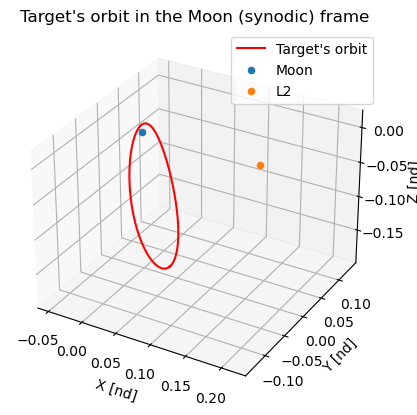

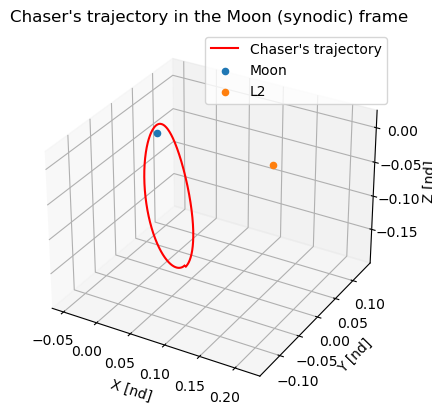

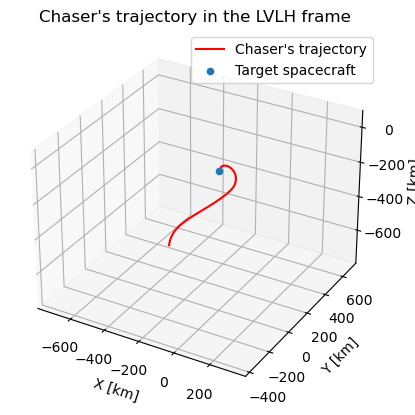

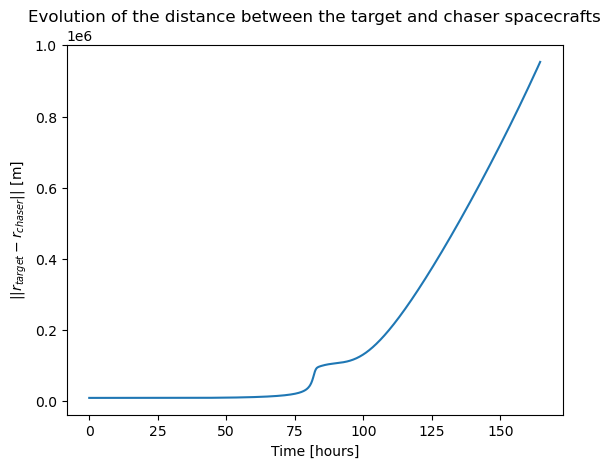

In [2170]:
# Setting the initial conditions for the chaser. We'll use the same orbit as the precedent one for the target.
# Initial conditions for the chaser are defined in the LVLH frame

# Maybe do that in another file and save it in a csv file so that the initial conditions don't change everytime we run the code here
# So that we can actually compare results with the same initial conditions more easily
distance_to_target_km = 10 # in km, CHANGE to see to which extent the linear approximation works (try up to 100km in the article)
distance_to_target = distance_to_target_km/r12 # adimensionalized initial condition

rho_x0_LVLH = rand()*distance_to_target # NOT ENTIRELY RANDOM SINCE IT CAN'T BE NEGATIVE, CHANGE THAT!!!
rho_y0_LVLH = rand()*np.sqrt(distance_to_target**2 - rho_x0_LVLH**2)
rho_z0_LVLH = np.sqrt(distance_to_target**2 - rho_x0_LVLH**2 - rho_y0_LVLH**2)

velocity_rel_target_km = 0 # in km/s, CHANGE to see to which extent the linear approximation works
velocity_rel_target = velocity_rel_target_km/r12*TU # adimensionalized initial condition

rho_vx0_LVLH = rand()*velocity_rel_target
rho_vy0_LVLH = rand()*np.sqrt(velocity_rel_target**2 - rho_vx0_LVLH**2)
rho_vz0_LVLH = np.sqrt(velocity_rel_target**2 - rho_vx0_LVLH**2 - rho_vy0_LVLH**2)
print(rho_vx0_LVLH,rho_vy0_LVLH,rho_vz0_LVLH)

# Initial conditions to integrate the relative dynamics
# The initial conditions are in the Moon frame for the target part and in the LVLH frame for the chaser part
initial_conditions_chaser_LVLH = [x0_M, y0_M, z0_M, vx0_M, vy0_M, vz0_M, rho_x0_LVLH, rho_y0_LVLH, rho_z0_LVLH, rho_vx0_LVLH, rho_vy0_LVLH, 
                                  rho_vz0_LVLH]

# Simulating the relative dynamics
y_orbit = integrate.odeint(propagator_relative,initial_conditions_chaser_LVLH,t_simulation[:],args=(mu,))

# Plotting the orbit of the target in the Moon frame -> maybe to a function to plot the stuff with diff inputs to know if we're dealing with
# chaser/target, which frame the data is in etc.?
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(-y_orbit[:,0], -y_orbit[:,1], y_orbit[:,2], color='r', label = "Target's orbit")
ax.scatter(0, 0, 0, label='Moon')
ax.scatter(L2x-(1-mu), 0, 0, label='L2')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Target's orbit in the Moon (synodic) frame")
plt.grid()
plt.show()

# C'est là que ça devient messy CLEAN UP
chaser_position = np.zeros((y_orbit.shape[0],3))
distance_target_chaser = np.zeros(y_orbit.shape[0])
rho_M_history = np.zeros_like(y_orbit[:,6:9])
rho_dot_M_history = np.zeros_like(y_orbit[:,9:])

for l in range(len(y_orbit[:,0])):
    r_M = y_orbit[l,:3].reshape((3,1))
    r_dot_M = y_orbit[l,3:6].reshape((3,1))

    # Compute the rotation matrix
    [A_M_LVLH,_,_,_] = M_to_LVLH(r_M,r_dot_M)
    
    rho_LVLH = y_orbit[l,6:9].reshape((3,1))
    rho_M = (A_M_LVLH.T)@rho_LVLH
    
    chaser_position[l,:3] = r_M.reshape(3) + rho_M.reshape(3) # in the Moon (synodic) frame
    
    distance_target_chaser[l] = la.norm(rho_M)
    rho_M_history[l] = rho_M.reshape(3)
    
    h = cross(r_M.reshape(3),r_dot_M.reshape(3))
    der = propagator_absolute([r_M[0],r_M[1],r_M[2],r_dot_M[0],r_dot_M[1],r_dot_M[2]],0,mu)
    r_ddot_M = der[3:]
    omega_lm_LVLH = np.zeros((3,1))
    omega_lm_LVLH[1] = -la.norm(h)/la.norm(r_M)**2
    omega_lm_LVLH[2] = -la.norm(r_M)/la.norm(h)**2 * np.dot(h,r_ddot_M.reshape(3))
    rho_dot_LVLH = y_orbit[l,9:].reshape((3,1)) + cross(omega_lm_LVLH.reshape(3),rho_LVLH.reshape(3)).reshape((3,1))
    rho_dot_M = (A_M_LVLH.T)@rho_dot_LVLH
    rho_dot_M_history[l] = rho_dot_M.reshape(3)
    
# Plotting of the chaser's position in the Moon frame
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(-chaser_position[:,0], -chaser_position[:,1], chaser_position[:,2], color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Moon')
ax.scatter(L2x-(1-mu), 0, 0, label='L2')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Chaser's trajectory in the Moon (synodic) frame")
plt.grid()
plt.show()

# Plotting of the chaser's position in the LVLH frame
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_orbit[:,6]*r12, y_orbit[:,7]*r12, y_orbit[:,8]*r12, color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Target spacecraft')
ax.axis('equal')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.legend()
plt.title("Chaser's trajectory in the LVLH frame")
plt.grid()
plt.show()

# Plotting the distance between the target and the chaser over time
plt.plot(t_simulation*TU/3600,distance_target_chaser*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r'||$r_{target}-r_{chaser}$|| [m]')
plt.title("Evolution of the distance between the target and chaser spacecrafts")
plt.show()

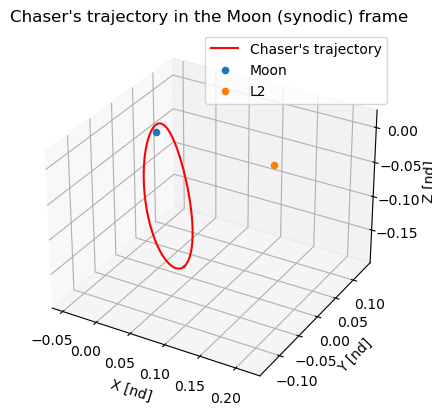

In [2171]:
# Computing the initial LVLH frame to get the rotation matrix and get the initial conditions in the Moon synodic frame
r_M_init = np.asarray([[x0_M],[y0_M],[z0_M]])
r_dot_M_init = np.asarray([[vx0_M],[vy0_M],[vz0_M]])  

[A_M_LVLH_init,_,_,_] = M_to_LVLH(r_M_init.reshape(3),r_dot_M_init.reshape(3))
rho_init_LVLH = np.asarray([[rho_x0_LVLH],[rho_y0_LVLH],[rho_z0_LVLH]]).reshape((3,1))
rho_init_M = ((A_M_LVLH_init.T)@rho_init_LVLH).reshape(3)
[rho_x0_M,rho_y0_M,rho_z0_M] = ((A_M_LVLH_init.T)@rho_init_LVLH).reshape(3)

h_init = cross(initial_conditions_M[:3],initial_conditions_M[3:])
der_state_init = propagator_absolute(initial_conditions_M,0,mu)
r_ddot_M_init = der_state_init[3:6]
omega_lm_LVLH_init = np.zeros(3)
omega_lm_LVLH_init[1] = - la.norm(h_init)/(la.norm(initial_conditions_M[:3])**2)
omega_lm_LVLH_init[2] = -la.norm(initial_conditions_M[:3])/(la.norm(h_init)**2) * np.dot(h_init, r_ddot_M_init)

rho_dot_init_LVLH = np.zeros((3,1))
rho_dot_init_LVLH[0] = rho_vx0_LVLH
rho_dot_init_LVLH[1] = rho_vy0_LVLH
rho_dot_init_LVLH[2] = rho_vz0_LVLH

rho_dot_init_M = (A_M_LVLH_init.T)@(rho_dot_init_LVLH + cross(omega_lm_LVLH_init.reshape(3),rho_init_LVLH.reshape(3)).reshape((3,1)))
rho_vx0_M = rho_dot_init_M[0,0]
rho_vy0_M = rho_dot_init_M[1,0]
rho_vz0_M = rho_dot_init_M[2,0]

initial_conditions_chaser_M = [x0_M + rho_x0_M, y0_M + rho_y0_M, z0_M + rho_z0_M, vx0_M + rho_vx0_M, vy0_M + rho_vy0_M, vz0_M + rho_vz0_M]

# Simulating over a full orbit of the target, might be too much where the linear conditions aren't valid anymore
chaser_orbit = integrate.odeint(propagator_absolute,initial_conditions_chaser_M,t_simulation[:],args=(mu,))

# Plotting the orbit of the target
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(-chaser_orbit[:,0], -chaser_orbit[:,1], chaser_orbit[:,2], color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Moon')
ax.scatter(L2x-(1-mu), 0, 0, label='L2')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Chaser's trajectory in the Moon (synodic) frame")
plt.grid()
plt.show()

# Also compare the initial velocity to see if they match (careful with reference frames and how to go from one to the other)
# Once everything's solved, clean up the code (or could be even be helpful to debug it)

# Try with an orbit that looks more like the one in the article, for now my results are worse than theirs -> find out why
# Compare initial conditions just as a sanity check

Computing the norm of the difference between the two chaser's trajectories

In [2172]:
# Careful, here I compare the positions of the chaser with respect to the Moon when they compare just rho in the article

# CHECK HOW I COMPUTE rho AND rho_dot IN THE LVLH FRAME COMING FROM THE M FRAME

norm_error_abs = np.zeros(len(chaser_orbit[:,0]))
norm_error_rel = np.zeros(len(chaser_orbit[:,0]))
rho_M_history_true = np.zeros_like(y_orbit[:,6:9])
rho_dot_M_history_true = np.zeros_like(y_orbit[:,9:])
rho_LVLH_history_true = np.zeros_like(y_orbit[:,6:9])
rho_dot_LVLH_history_true = np.zeros_like(y_orbit[:,9:])
for i in range(len(chaser_orbit[:,0])):
    error = np.zeros((3,1))
    error[0] = -chaser_orbit[i,0]+chaser_position[i,0]
    error[1] = -chaser_orbit[i,1]+chaser_position[i,1]
    error[2] = chaser_orbit[i,2]-chaser_position[i,2]
    norm_error_abs[i] = la.norm(error)
    error2 = la.norm(error)/la.norm(y_orbit[i,6:9])
    norm_error_rel[i] = error2
    
    rho_M = chaser_orbit[i,:3] - y_orbit[i,:3]
    rho_dot_M = chaser_orbit[i,3:] - y_orbit[i,3:6]
    
    rho_M_history_true[i] = rho_M.reshape(3)
    rho_dot_M_history_true[i] = rho_dot_M.reshape(3)
    
    A_M_LVLH,_,_,_ = M_to_LVLH(y_orbit[i,:3],y_orbit[i,3:6])
    rho_LVLH = A_M_LVLH @ (rho_M.reshape((3,1)))
    h = np.cross(y_orbit[i,:3].reshape(3),y_orbit[i,3:6].reshape(3))
    der = propagator_absolute(y_orbit[i,:6],0,mu)
    r_ddot = der[3:]
    omega_lm_LVLH = np.zeros((3,1))
    omega_lm_LVLH[1] = - la.norm(h)/(la.norm(y_orbit[i,:3])**2)
    omega_lm_LVLH[2] = - la.norm(y_orbit[i,:3])/(la.norm(h)**2) * np.dot(h.reshape(3),r_ddot.reshape(3))
    rho_dot_LVLH = A_M_LVLH @ rho_dot_M.reshape((3,1)) - np.cross(omega_lm_LVLH.reshape(3),rho_LVLH.reshape(3)).reshape((3,1))
    
    rho_LVLH_history_true[i] = rho_LVLH.reshape(3)
    rho_dot_LVLH_history_true[i] = rho_dot_LVLH.reshape(3)

print(rho_dot_LVLH_history_true) # THERE IS AN ISSUE WITH HOW I COMPUTE rho_dot_LVLH from rho_dot_M

[[ 7.13964071e-18 -1.69406589e-21  1.69406589e-21]
 [-6.99177497e-08 -3.00200250e-09  6.39359272e-08]
 [-1.39688432e-07 -5.98889436e-09  1.27870825e-07]
 ...
 [-1.84564259e-05 -3.42802040e-05  1.01871111e-04]
 [-1.84520150e-05 -3.42430728e-05  1.02099385e-04]
 [-1.84471180e-05 -3.42058104e-05  1.02328593e-04]]


## Saving the trajectories in a cvs file to use in the optimization code

In [2173]:
# Saving the target and chaser spacecrafts' trajectories in a csv file
file = open("target_chaser_trajectories.csv","w")
writer = csv.writer(file)
for l in range(len(y_orbit[:,0])):
    if l>0:
        # To save the target trajectory and the propagation of the chaser's trajectory with NON-LINEAR dynamics
        data = np.concatenate(([t_simulation[l]],y_orbit[l,:6],rho_LVLH_history_true[l,:],rho_dot_LVLH_history_true[l,:]))
    elif l == 0:
        # To save the target trajectory and the propagation of the chaser's trajectory with LINEAR dynamics
        data = np.concatenate(([t_simulation[l]],y_orbit[l,:]))
    writer.writerow(data)
file.close()

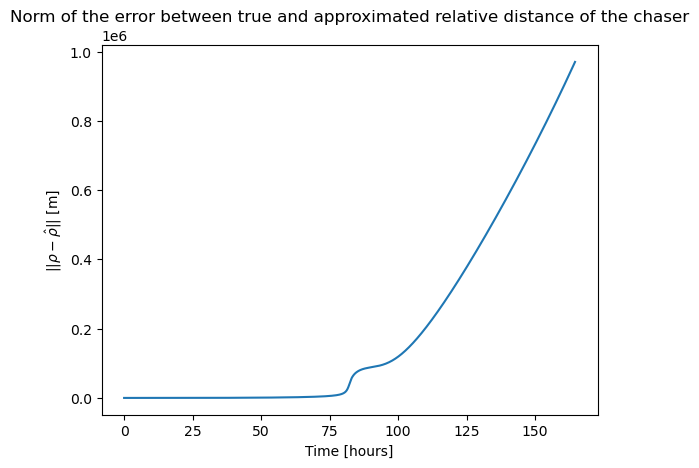

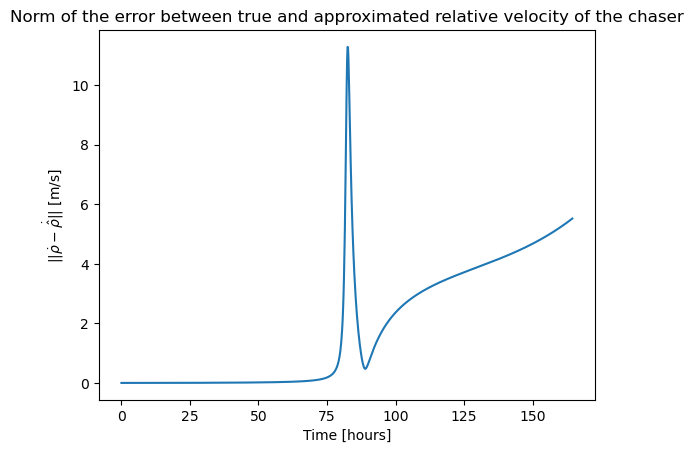

In [2174]:
# Computing the same error as in the article (error on rho and rho_dot), we'll compare them in the Moon frame
norm_er = np.zeros(rho_M_history.shape[0])
norm_ev = np.zeros(rho_M_history.shape[0])
for i in range(rho_M_history.shape[0]):
    er = - rho_M_history[i] + rho_M_history_true[i]
    norm_er[i] = la.norm(er)
    ev = - rho_dot_M_history[i] + rho_dot_M_history_true[i]
    norm_ev[i] = la.norm(ev)
    
plt.plot(t_simulation*TU/3600,norm_er*r12*1e3) # error in meter
plt.xlabel('Time [hours]')
plt.ylabel(r'$||\rho - \hat{\rho}||$ [m]')
plt.title(r'Norm of the error between true and approximated relative distance of the chaser')
plt.show()

plt.plot(t_simulation*TU/3600,norm_ev*r12*1e3/TU) # will get the velocity in m/s!
plt.xlabel('Time [hours]')
plt.ylabel(r'$||\dot{\rho} - \dot{\hat{\rho}}||$ [m/s]')
plt.title(r'Norm of the error between true and approximated relative velocity of the chaser')
plt.show()

## Comparing to just multiplying with the State Transition Matrix (STM)

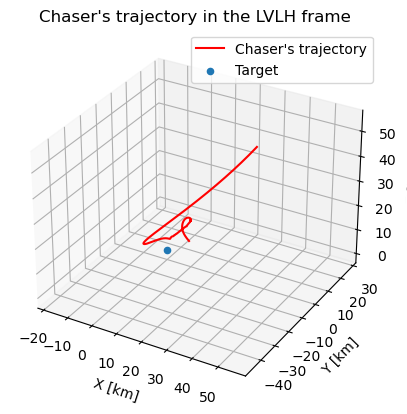

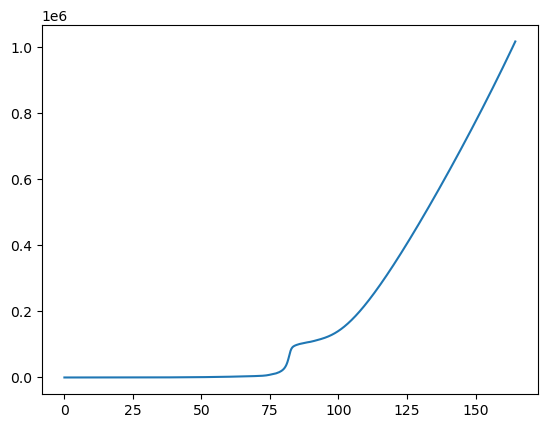

In [2175]:
# We already have the target's reference trajectory, so for every step, we compute the STM
chaser_trajectory = np.zeros_like(y_orbit[:,:6])
chaser_trajectory[0,0] = rho_x0_LVLH
chaser_trajectory[0,1] = rho_y0_LVLH
chaser_trajectory[0,2] = rho_z0_LVLH
chaser_trajectory[0,3] = rho_vx0_LVLH
chaser_trajectory[0,4] = rho_vy0_LVLH
chaser_trajectory[0,5] = rho_vz0_LVLH
for i in range(1,y_orbit.shape[0]):
    delta_t = t_simulation[i]-t_simulation[i-1]
    stm = propagator_relative_with_matrix(y_orbit[i,:6],delta_t,mu)
    chaser_trajectory[i,:] = (stm @ chaser_trajectory[i-1,:].reshape((6,1))).reshape(6)
    
# Plotting the orbit of the target
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(chaser_trajectory[:,0]*r12, chaser_trajectory[:,1]*r12, chaser_trajectory[:,2]*r12, color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Target')
ax.axis('equal')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.legend()
plt.title("Chaser's trajectory in the LVLH frame")
plt.grid()
plt.show()

error_lin_stm = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error = la.norm(chaser_trajectory[i,:3] - y_orbit[i,6:9]) # both should be in the LVLH frame
    error_lin_stm[i] = error

plt.plot(t_simulation*TU/3600,error_lin_stm*r12*1e3)
plt.show()

# Interesting, matrix dynamics and propagator_relative_with_matrix yield different results when they should be exactly the same

In [2176]:
# # Saving the target and chaser spacecrafts' trajectories in a csv file
# file = open("target_chaser_trajectories.csv","w")
# writer = csv.writer(file)
# for l in range(len(y_orbit[:,0])):
#     if l>0:
#         # To save the target trajectory and the propagation of the chaser's trajectory with NON-LINEAR dynamics
#         data = np.concatenate(([t_simulation[l]],y_orbit[l,:6],chaser_trajectory[l,:]))
#     elif l == 0:
#         # To save the target trajectory and the propagation of the chaser's trajectory with LINEAR dynamics
#         data = np.concatenate(([t_simulation[l]],y_orbit[l,:]))
#     writer.writerow(data)
# file.close()

Integrating the functions where derivative is computing with the dynamics in the matrix form

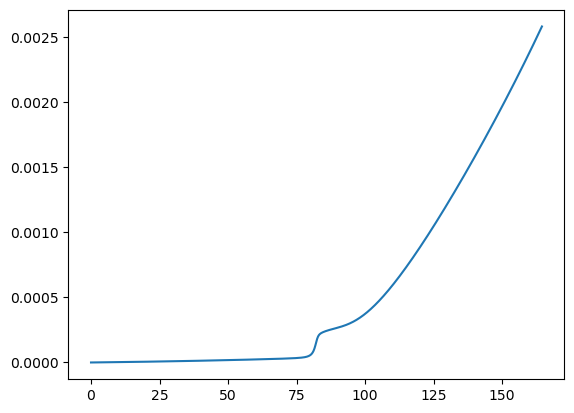

In [2177]:
matrix_dyn1 = integrate.odeint(integrate_matrix1,initial_conditions_chaser_LVLH,t_simulation,args=(mu,))

error_mat1_lin = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error = la.norm(matrix_dyn1[i,6:9]-y_orbit[i,6:9])
    error_mat1_lin[i] = error
    
plt.plot(t_simulation*TU/3600,error_mat1_lin)
plt.show()

[-3.91194421e-02  1.06204250e-26 -1.85306065e-01 -1.83390077e-14
  1.13785515e-01  1.31515451e-13]
[-3.91194421e-02  1.06204250e-26 -1.85306065e-01]
[-3.91194421e-02  2.19175289e-08 -1.85306065e-01  2.76356982e-08
  1.13785515e-01  9.38251768e-08]
[-3.91194421e-02  2.19175289e-08 -1.85306065e-01]
[-3.91194421e-02  2.19175289e-08 -1.85306065e-01  2.76356982e-08
  1.13785515e-01  9.38251768e-08]
[-3.91194421e-02  2.19175289e-08 -1.85306065e-01]
[-3.91194421e-02  4.38350579e-08 -1.85306065e-01  5.52714148e-08
  1.13785515e-01  1.87650222e-07]
[-3.91194421e-02  4.38350579e-08 -1.85306065e-01]
[-3.91194421e-02  4.38350579e-08 -1.85306065e-01  5.52714148e-08
  1.13785515e-01  1.87650222e-07]
[-3.91194421e-02  4.38350579e-08 -1.85306065e-01]
[-0.03911918  0.00021922 -0.18530516  0.00027641  0.11378464  0.00093844]
[-0.03911918  0.00021922 -0.18530516]
[-0.03911918  0.00021922 -0.18530516  0.00027641  0.11378464  0.00093844]
[-0.03911918  0.00021922 -0.18530516]
[-0.03911838  0.00043839 -0.185

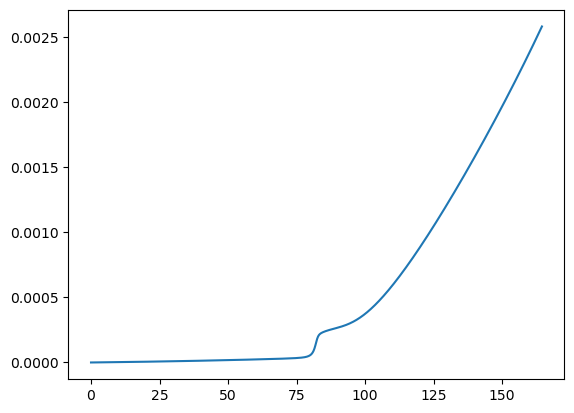

In [2178]:
matrix_dyn2 = integrate.odeint(integrate_matrix2,initial_conditions_chaser_LVLH,t_simulation,args=(mu,))

error_mat2_lin = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error = la.norm(matrix_dyn1[i,6:9]-y_orbit[i,6:9])
    error_mat2_lin[i] = error
    
plt.plot(t_simulation*TU/3600,error_mat2_lin)
plt.show()

## OPTIONAL: WORK ON IT LATER (when having free time)
Need to implement the elliptical 3bp formulation since it is what they compare their results with in the article

Using the equations for vectors in an inertial frame because I don't know how to compute omega_m/i or omega_m/i_dot in the Moon frame (is it the same as if I compute it in the inertial frame? but just rotate to another frame?)

## Verification of the target's orbit around the Moon with the new propagator (Hide this at some point, not useful anymore)
First check that the implementation of the new dynamics with respect to the Moon are correct, comparing 3 different propagators

Verification ok, we get the same orbit as with the 3 different propagators